In [1]:
import warnings
from io import StringIO
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

**This tutorial is for R users. If you are using Python, check out [this other tutorial instead!](https://quentinandre.net/post/clean-analyze-distbuilder-data-r)**

You have just completed a simple distribution builder study on a Qualtrics.

* Participants have been randomly assigned to one of two conditions ("Low" or "High"), and have learned a distribution of numbers ranging from 11 to 20.
* After learning the distribution, they had to predict the next 10 numbers that would appear in the distribution.
* To do so, they allocated 10 balls (representing the next 10 draws) to 10 buckets [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] (representing the possible outcomes).

Here is the data for the first five participants:

In [2]:
data = """part_id,condition,allocation
A,Low,"3,1,0,2,1,0,0,0,1,2"
B,High,"0,0,2,0,2,0,1,2,0,3"
C,High,"3,0,0,2,1,0,0,0,3,1"
D,Low,"2,1,0,2,0,1,2,0,1,1"
E,Low,"3,2,0,0,0,1,0,3,0,1"
F,High,"0,0,2,0,0,1,2,0,2,3"
G,Low,"1,3,0,3,0,2,0,1,0,0"
H,High,"0,1,3,0,0,1,2,2,1,0"
I,High,"2,2,0,0,0,2,1,0,0,3"
J,Low,"1,3,1,0,2,2,0,0,0,1"
K,Low,"1,3,1,0,0,1,2,1,1,0"
L,Low,"3,1,2,1,0,1,0,1,0,1"
M,Low,"0,2,2,0,1,3,0,2,0,0"
N,Low,"1,3,0,2,0,1,1,1,1,0"
O,High,"0,0,1,3,1,0,0,3,0,2"
P,High,"1,1,2,0,0,0,2,0,2,2"
Q,High,"1,1,0,0,0,0,3,2,2,1"
R,High,"2,0,0,0,0,2,3,0,3,0"
S,High,"0,1,3,2,0,0,0,0,1,3"
T,Low,"1,3,1,0,1,0,3,0,0,1"
"""
df = pd.read_csv(StringIO(data), sep=",")
df.head()

,part_id,condition,allocation
0,A,Low,"3,1,0,2,1,0,0,0,1,2"
1,B,High,"0,0,2,0,2,0,1,2,0,3"
2,C,High,"3,0,0,2,1,0,0,0,3,1"
3,D,Low,"2,1,0,2,0,1,2,0,1,1"
4,E,Low,"3,2,0,0,0,1,0,3,0,1"


## 1. Data Wrangling: Making the raw data usable

If you look at the raw data from Qualtrics, you can see that the column "allocation" has stored the allocation provided by each participant.

However, those allocations are not interpretable right now:
1. The allocations are stored as a string (and not as a list of numbers).
2. This numbers in this *allocation* are not the values of the *distribution*: those are the number of balls in each bucket. You can see that all the values are below 10, while the buckets ranged from 11 to 20.

Let's review how you should transform this data, and what you can do with it.

The first step is to write a function and convert those allocations to distributions.

### A. Converting the allocations into distributions

In [3]:
def convert_allocation_to_distribution(allocation, buckets):
    """
    Takes an allocation of balls to buckets, and a list of buckets.
    Return the corresponding distribution of values.

    Example:
        buckets = [1, 2, 3, 4, 5]
        x = "0, 3, 1, 2, 1"
        dist = convert_allocation_to_distribution(x, buckets)
        print(dist) -> (2, 2, 2, 3, 4, 4, 5)
    """
    arr = allocation.split(",")

    if len(arr) != len(buckets):
        raise ValueError(
            "The number of buckets should match the length of the allocations."
        )
    values = np.repeat(buckets, arr)
    return values

Now we apply this function to the column "allocation", specifying that the buckets ranged from 11 to 20.

In [4]:
df["distribution"] = df["allocation"].apply(
    convert_allocation_to_distribution,
    buckets=[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
)
df.head()

,part_id,condition,allocation,distribution
0,A,Low,"3,1,0,2,1,0,0,0,1,2","[11, 11, 11, 12, 14, 14, 15, 19, 20, 20]"
1,B,High,"0,0,2,0,2,0,1,2,0,3","[13, 13, 15, 15, 17, 18, 18, 20, 20, 20]"
2,C,High,"3,0,0,2,1,0,0,0,3,1","[11, 11, 11, 14, 14, 15, 19, 19, 19, 20]"
3,D,Low,"2,1,0,2,0,1,2,0,1,1","[11, 11, 12, 14, 14, 16, 17, 17, 19, 20]"
4,E,Low,"3,2,0,0,0,1,0,3,0,1","[11, 11, 11, 12, 12, 16, 18, 18, 18, 20]"


Good! The raw allocation strings have now been converted to the actual distribution provided by participants.

However, the data is in a nice shape: the data for each participant is stored as a list of number in a single column. Ideally, we'd like a format that we can use to do analysis and graphs.

### B. Pivoting the distributions in long form

We are now going to reshape the data in long form, such that one record corresponds to one value entered by one participant.

In [5]:
part_values = (
    df.set_index("part_id").distribution.apply(pd.Series).stack().reset_index()
)
part_values.columns = ["part_id", "value_index", "value"]

Let's first check that we have the expected number of records:

In [6]:
display(HTML(f"""We have a total of {part_values.shape[0]} observations
             (20 participants times 10 values per participant)"""))

Now if we inspect the head of the dataset...

In [7]:
part_values.head()

,part_id,value_index,value
0,A,0,11
1,A,1,11
2,A,2,11
3,A,3,12
4,A,4,14


...we see that we have the list of all values, but that we no longer have the participant-level information (such as the condition to which they were assigned).

To correct this, we need to merge those values with the original dataset on the column `part_id`.

### c. Merging back the rest of the data

Before merging, we can also drop the columns "distribution" and "allocation", which are no longer needed.

In [8]:
df_long = part_values.merge(
    df.drop(["distribution", "allocation"], axis=1), on="part_id"
)
df_long.head()

,part_id,value_index,value,condition
0,A,0,11,Low
1,A,1,11,Low
2,A,2,11,Low
3,A,3,12,Low
4,A,4,14,Low


We now have everything in long form:
* The participant-level information
* All the values of the distributions provided by the participants

We are now ready for some visualization and statistical analysis.

## 2. Visualizing the data

The first thing you can do is to inspect the distributions provided by the participants:

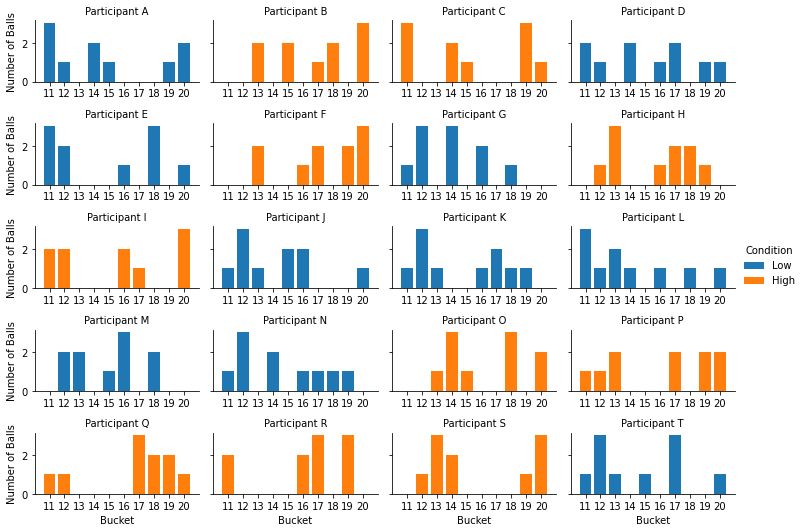

In [9]:
bins = np.arange(11, 21.1, 1)
xticks = np.arange(11, 20.1, 1)
g = sns.FacetGrid(
    data=df_long,
    col="part_id",
    col_wrap=4,
    hue="condition",
    sharex=False,
    height=1.5,
    aspect=1.7,
)
g.map(plt.hist, "value", bins=bins, histtype="bar", rwidth=0.8, align="left")
g.set_ylabels("Number of Balls")
g.set_xlabels("Bucket")
g.set(xticks=xticks)
g.set_titles("Participant {col_name}")
g.set(xlim=(10, 21))
g.add_legend(title="Condition")
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig1"))

Those distributions look pretty random (because they were randomly generated), but at least we can see how each participant responded!

Note that we could also look at the distribution of responses by condition.

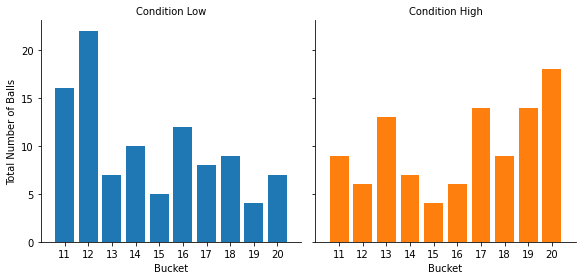

In [10]:
g = sns.FacetGrid(data=df_long, col="condition", hue="condition", height=4)
g.map(plt.hist, "value", bins=bins, lw=1, rwidth=0.8, align="left")
g.set_ylabels("Total Number of Balls")
g.set_xlabels("Bucket")
g.set(xticks=xticks)
g.set_titles("Condition {col_name}")
g.set(xlim=(10, 21))
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig2"))

The visualization tells us the distribution within each condition, but we cannot compare the two conditions (unless you have the exact same number of participant in each condition).

If if is not the case, we can visualize the mean number of balls in each bucket and each condition by applying a simple transformation:

In [11]:
mean_values = (
    df_long.groupby(["part_id", "value", "condition"])
    .count()
    .reset_index()
    .groupby(["condition", "value"])
    .mean()
    .reset_index()
)
mean_values.columns = ["condition", "value", "mean"]
mean_values.head()

,condition,value,mean
0,High,11,1.800000
1,High,12,1.200000
2,High,13,2.166667
3,High,14,2.333333
4,High,15,1.333333


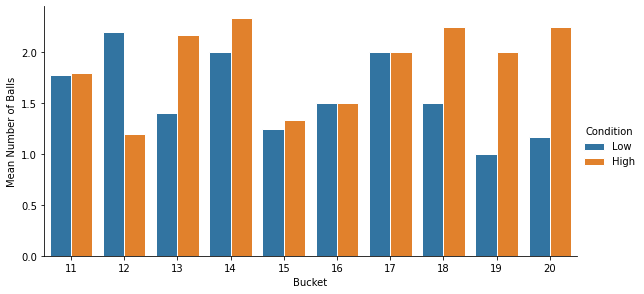

In [12]:
g = sns.catplot(
    x="value",
    y="mean",
    hue="condition",
    hue_order=["Low", "High"],
    data=mean_values,
    kind="bar",
    ec="white",
    height=4,
    aspect=2,
    legend=False,
)
g.set_ylabels("Mean Number of Balls")
g.set_xlabels("Bucket")
g.add_legend(title="Condition")
g.set_titles("Condition {col_name}")
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig3"))

## 3. Analyzing properties of the distributions

**The analysis of the data always depends on the research question.**

So far, we have taken a descriptive approach to the data: We considered that we have collected 10 values from each participant, and have analyzed the data as such.

However, we could have collected the data with the specific goal of testing people's beliefs about particular properties of the distribution:
* We could be interested in what is the *average value* that people expect (i.e., the mean)
* We could be interested in how *dispersed* participants expect the distribution to be (e.g., standard deviation).
* We could be interested in how *skewed* they expect it to be...

In that case, the relevant unit of analysis is the *statistics* computed at the distribution's level.

We need to group the data by `part_id`, and compute the statistics of interest, to obtain one data point per participant.

In [13]:
df_agg = (
    df_long
    .groupby("part_id")
    .value
    .aggregate(["mean", "std", "skew"])
    .reset_index()
    .merge(
        df.drop(["allocation", "distribution"], axis=1),
        on="part_id"
    )
)
df_agg.head()

,part_id,mean,std,skew,condition
0,A,14.7,3.713339,0.555959,Low
1,B,16.9,2.766867,-0.264377,High
2,C,15.3,3.683296,0.035688,High
3,D,15.1,3.212822,0.088451,Low
4,E,14.7,3.622461,0.197400,Low


We can now see if our condition had an impact on people's perceived mean of the distribution:

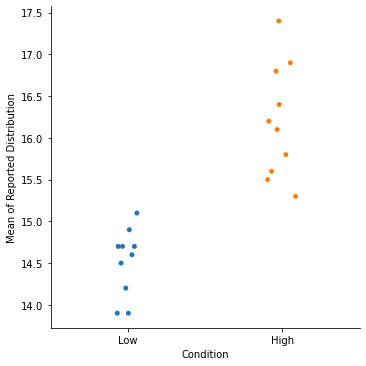

In [14]:
g = sns.catplot(x="condition", y="mean", data=df_agg)
g.set_xlabels("Condition")
g.set_ylabels("Mean of Reported Distribution")
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig4"))

Here, we see that participants in the "Low" condition reported a significantly lower mean that participants in the "High" condition (which is exactly how I created the data, so not so surprising...).

## 4. Wrapping up

We have seen how to convert the raw data generated by distBuilder to a standard long form dataset.

A few words of caution to finish:
* Always check that the list of buckets you use in the analysis matches the list of buckets that was shown to participants.
* Always check your number of records. If something is off, you might have missing data, or you might not have forced participants to submit a full distribution.
* Always ask yourself: what is my unit of analysis? Is it the values provided by participants, or is it a summary statistics of their total reported distribution?